In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from rumbooster import rum_train

from sklearn.model_selection import train_test_split

In [2]:
swissmetro = pd.read_table('Data/swissmetro.dat')

keep = (( swissmetro['PURPOSE'] != 1 ) * ( swissmetro['PURPOSE'] != 3 ) + ( swissmetro['CHOICE'] == 0 )) == 0
#swissmetro.drop(swissmetro[exclude].index, inplace=True).reset_index(inplace=True, drop=True)
swissmetro = swissmetro[keep]

In [3]:
new_train_co = swissmetro['TRAIN_CO'] * (swissmetro['GA']==0)
new_sm_co = swissmetro['SM_CO'] * (swissmetro['GA']==0)

In [4]:
feature = swissmetro[['TRAIN_TT', 'TRAIN_CO', 'TRAIN_HE', 'SM_TT', 'SM_CO', 'SM_HE', 'CAR_TT', 'CAR_CO']]

In [5]:
feature['TRAIN_CO'] = new_train_co
feature['SM_CO'] = new_sm_co

C:\Users\nicol\AppData\Local\Temp\ipykernel_5564\958357240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature['TRAIN_CO'] = new_train_co
C:\Users\nicol\AppData\Local\Temp\ipykernel_5564\958357240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature['SM_CO'] = new_sm_co


In [6]:
choice = swissmetro[['CHOICE']] -1

In [7]:
X_train, X_test, y_train, y_test = train_test_split(feature, choice, test_size=0.2, random_state = 42)

In [8]:
param = {'max_depth': 1, 
         'num_boost_round': 150, 
         'objective':'multiclass',
         'monotone_constraints': [-1, -1, -1, -1, -1, -1, -1, -1], 
         'interaction_constraints': [[0], [1], [2], [3], [4], [5], [6], [7]],
         'learning_rate': 0.1,
         'verbosity': 2,
         'num_classes': 3,
         'linear_tree': False
        }

In [9]:
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
validation_data = lgb.Dataset(X_test, label=y_test, reference= train_data, free_raw_data=False)

In [10]:
rum_structure_1= [{'columns': ['TRAIN_TT', 'TRAIN_CO', 'TRAIN_HE'], 
                  'monotone_constraints': [-1, -1, -1], 
                  'interaction_constraints': [[0, 1, 2]]}, 
                 {'columns': ['SM_TT', 'SM_CO', 'SM_HE'], 
                  'monotone_constraints': [-1, -1, -1], 
                  'interaction_constraints': [[0, 1, 2]]},
                 {'columns': ['CAR_TT', 'CAR_CO'], 
                  'monotone_constraints': [-1, -1], 
                  'interaction_constraints': [[0, 1]]}]

In [11]:
lightgbm_1 = rum_train(param, train_data, valid_sets=[validation_data], rum_structure= rum_structure_1)

c:\Users\nicol\OneDrive - University College London\Documents\PhD - UCL\GBM feature extraction\Multiclass problem\rumbooster.py:841: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\nicol\Anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\nicol\Anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\nicol\Anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


[LightGBM] [Info] Number of positive: 747, number of negative: 4667
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.044884
[LightGBM] [Debug] init for col-wise cost 0.000009 seconds, init for row-wise cost 0.000163 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 3
[LightGBM] [Info] Number of positive: 3250, number of negative: 2164
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.044884
[LightGBM] [Debug] init for col-wise cost 0.000007 seconds, init for row-wise cost 0.000118 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Numb

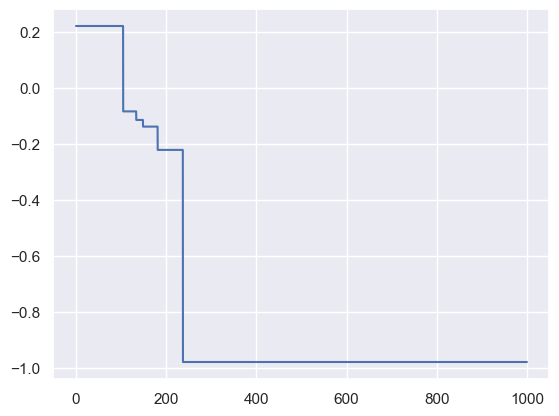

In [15]:
import matplotlib.pyplot as plt

def plot_util(j, f, F, start, stop, points=10000):
    xi=[]
    for i in range(F[j]):
        if i == f:
            xi.append(np.linspace(start,stop,points))
        else:
            xi.append(np.zeros(points))
    xin = np.array(xi).T
    booster = lightgbm_1.boosters[j]
    ypred = booster.predict(xin)
    plt.plot(np.linspace(start,stop,points), ypred)

plot_util(2, 1, [3, 3, 2], 0, 1000)


In [49]:
lightgbm_1.dump_model()

[{'name': 'tree',
  'version': 'v3',
  'num_class': 1,
  'num_tree_per_iteration': 1,
  'label_index': 0,
  'max_feature_idx': 2,
  'average_output': False,
  'feature_names': ['TRAIN_TT', 'TRAIN_CO', 'TRAIN_HE'],
  'monotone_constraints': [-1, -1, -1],
  'feature_infos': {'TRAIN_TT': {'min_value': 35,
    'max_value': 1022,
    'values': []},
   'TRAIN_CO': {'min_value': 0, 'max_value': 576, 'values': []},
   'TRAIN_HE': {'min_value': 30, 'max_value': 120, 'values': []}},
  'tree_info': [{'tree_index': 0,
    'num_leaves': 2,
    'num_cat': 0,
    'shrinkage': 0.1,
    'tree_structure': {'split_index': 0,
     'split_feature': 1,
     'split_gain': 427.47601318359375,
     'threshold': 16.500000000000004,
     'decision_type': '<=',
     'default_left': True,
     'missing_type': 'None',
     'internal_value': 0,
     'internal_weight': 0,
     'internal_count': 5414,
     'left_child': {'leaf_index': 0,
      'leaf_value': 0.057161126597343806,
      'leaf_weight': 173.77777907252312

In [12]:
param_unc = {'max_depth': 1, 
         'num_boost_round': 5, 
         'objective':'multiclass',
         'learning_rate': 0.1,
         'verbosity': 2,
         'num_classes': 3
        }

In [13]:
lightgbm_1_unc = lgb.train(param_unc, train_data, valid_sets=[validation_data])

c:\Users\nicol\Anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.076099
[LightGBM] [Debug] init for col-wise cost 0.000009 seconds, init for row-wise cost 0.000616 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 8
[LightGBM] [Info] Start training from score -1.980678
[LightGBM] [Info] Start training from score -0.510333
[LightGBM] [Info] Start training from score -1.340446
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[1]	valid_0's multi_logloss: 0.885374
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [De

c:\Users\nicol\Anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [48]:
X_train.columns

Index(['TRAIN_TT', 'TRAIN_CO', 'TRAIN_HE', 'SM_TT', 'SM_CO', 'SM_HE', 'CAR_TT',
       'CAR_CO'],
      dtype='object')

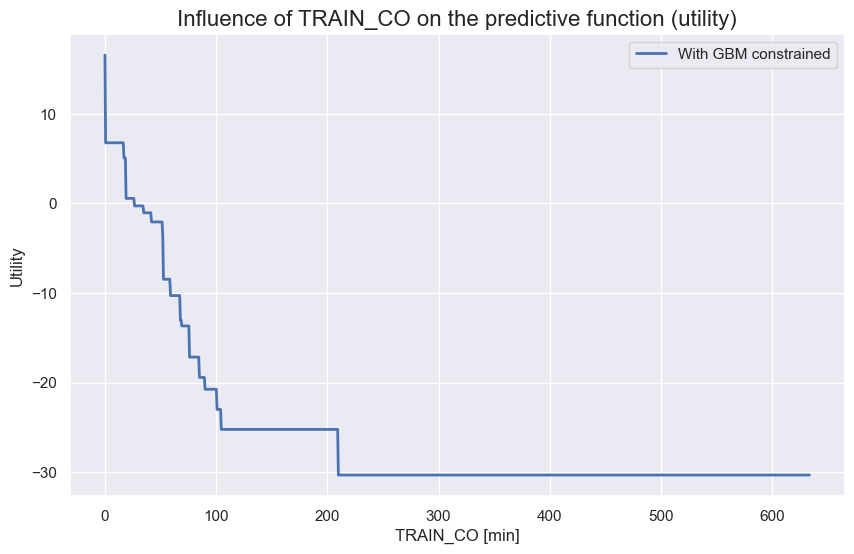

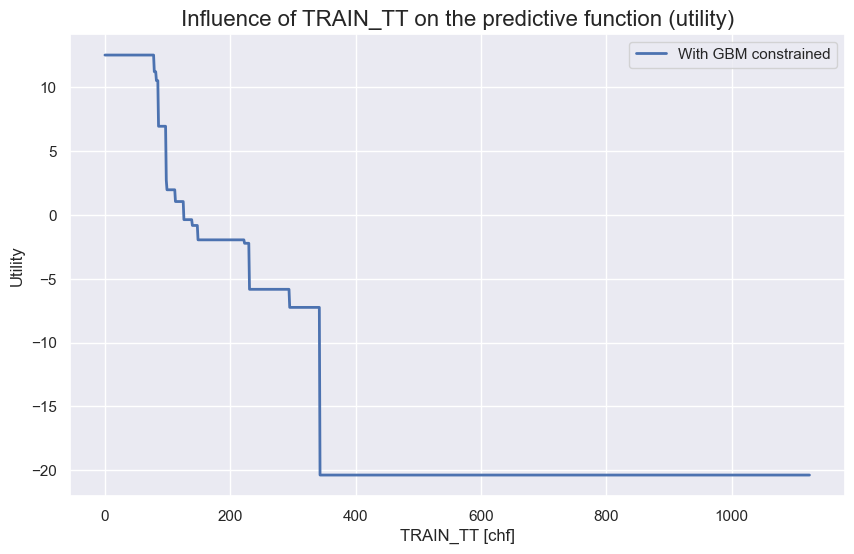

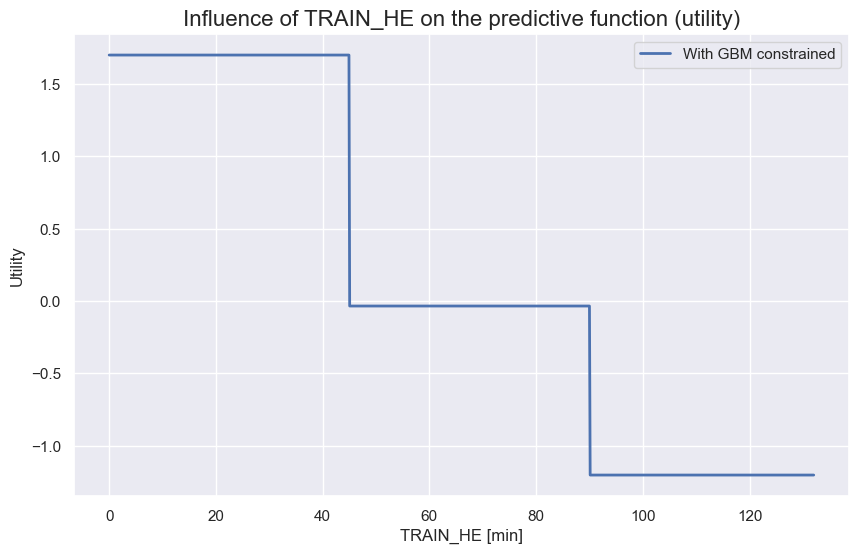

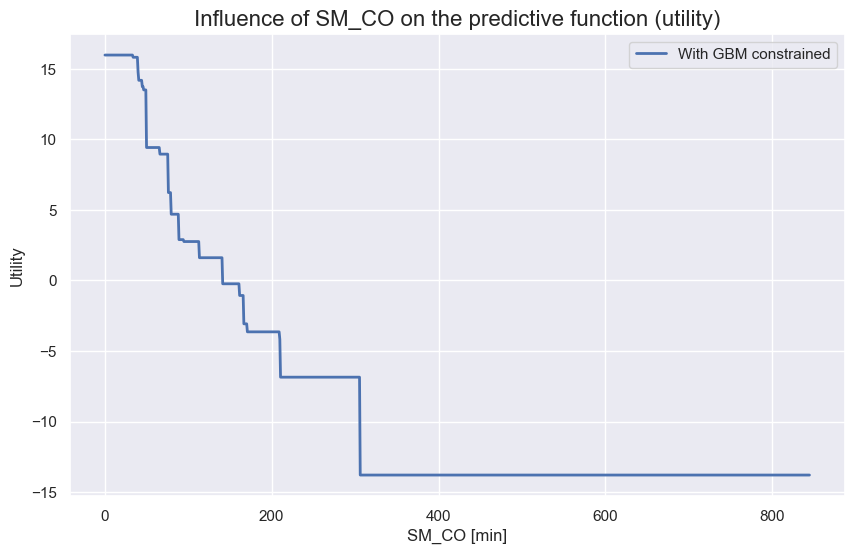

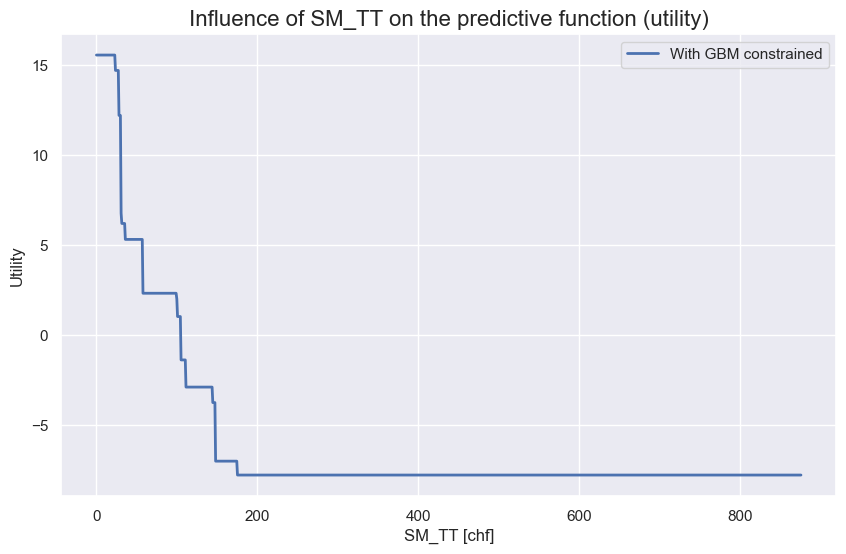

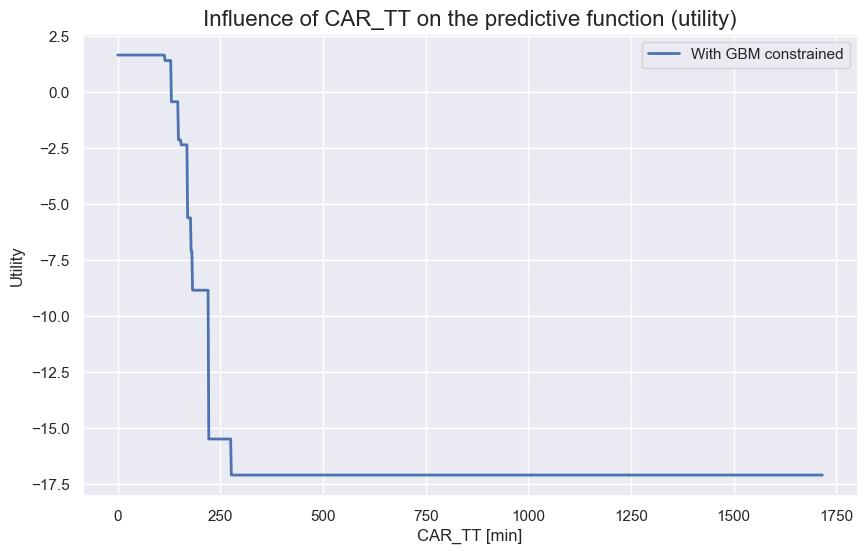

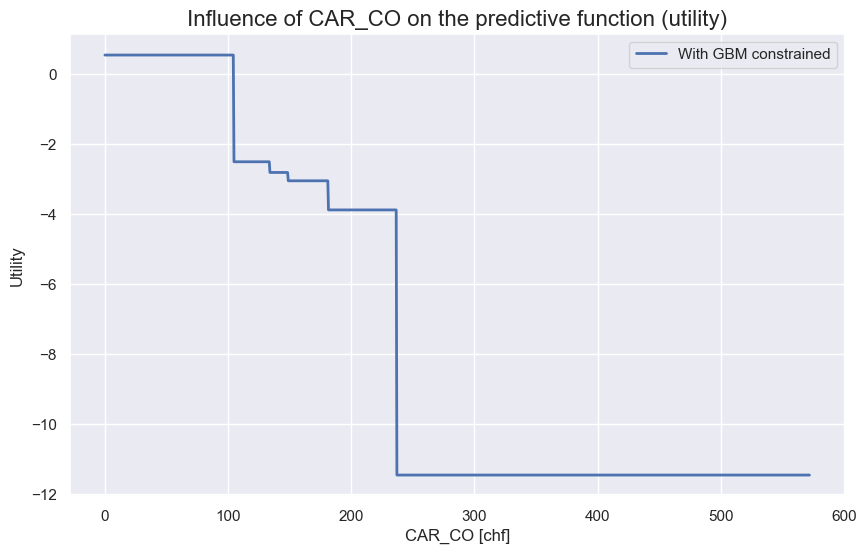

In [12]:
dict_labels = {'TRAIN_TT': 'chf', 
               'TRAIN_CO':'min', 
               'TRAIN_HE':'min', 
               'SM_TT':'chf', 
               'SM_CO':'min', 
               'SM_HE':'min',
               'CAR_TT': 'min', 
               'CAR_CO': 'chf'
               }

lightgbm_1.plot_parameters(param, X_train, dict_labels)

In [21]:
%run -i "Base_Model.py"

Obsolete syntax. Use generate_html instead of generateHtml
Obsolete syntax. Use generate_pickle instead of generatePickle


            Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CAR  0.212685      0.090920     2.339243      0.019323
ASC_SM   0.510729      0.109986     4.643591      0.000003
B_COST  -0.011023      0.000762   -14.461293      0.000000
B_HE    -0.005344      0.001103    -4.843324      0.000001
B_TIME  -0.012116      0.001239    -9.778750      0.000000
Nbr of observations: 5390
LL(0) = -4229.657
LL(beta) = -4229.657
rho bar square = -0.00118
Output file: None


In [14]:
london_data = pd.read_csv("../Binary problem/Data/dataset_london.csv")

london_with_driving_lic = london_data[london_data['driving_license']==1]

london_with_car = london_with_driving_lic[london_with_driving_lic['car_ownership']>0]

ld_with_one_trip = london_with_car.groupby(by=['household_id']).sample(1)

Feature = ld_with_one_trip[['travel_mode', 'survey_year', 'dur_walking', 'dur_cycling', 'dur_pt_total', 'dur_driving', 'cost_transit', 'cost_driving_total']]

X = Feature[['survey_year', 'dur_walking', 'dur_cycling', 'dur_pt_total', 'cost_transit', 'dur_driving', 'cost_driving_total']]
y = Feature[['travel_mode', 'survey_year']]


new_mode = {'drive':0, 'pt':1, 'cycle':2,'walk':3}

y = y.replace({'travel_mode': new_mode})


X_train = X[X['survey_year']<3]
X_validate =  X[X['survey_year']==3]
y_train = y[y['survey_year']<3]
y_validate = y[y['survey_year']==3]

X_train = X_train.drop(columns=['survey_year'])
X_validate = X_validate.drop(columns=['survey_year'])
y_train = y_train.drop(columns=['survey_year'])
y_validate = y_validate.drop(columns=['survey_year'])


In [15]:
param_ld = {'max_depth': 1, 
         'num_boost_round': 150, 
         'objective':'multiclass',
         'monotone_constraints': [-1, -1, -1, -1, -1, -1], 
         'interaction_constraints': [[0], [1], [2], [3], [4], [5]],
         'learning_rate': 0.3,
         'verbosity': 2,
         'num_classes': 4
        }

In [16]:
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
validation_data = lgb.Dataset(X_validate, label=y_validate, reference= train_data, free_raw_data=False)

In [17]:
rum_structure_ld= [{'columns': ['dur_driving', 'cost_driving_total'], 
                  'monotone_constraints': [-1, -1], 
                  'interaction_constraints': [[0, 1]]}, 
                 {'columns': [ 'dur_pt_total', 'cost_transit'], 
                  'monotone_constraints': [-1, -1], 
                  'interaction_constraints': [[0, 1]]},
                 {'columns': ['dur_cycling'], 
                  'monotone_constraints': [-1], 
                  'interaction_constraints': [[0]]},
                 {'columns': ['dur_walking'], 
                  'monotone_constraints': [-1], 
                  'interaction_constraints': [[0]]}]

In [18]:
lightgbm_ld = rum_train(param_ld, train_data, valid_sets=[validation_data], rum_structure= rum_structure_ld)

c:\Users\nicol\OneDrive - University College London\Documents\PhD - UCL\GBM feature extraction\Multiclass problem\rumbooster.py:840: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\nicol\Anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\nicol\Anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\nicol\Anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\nicol\Anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\basic.p

[LightGBM] [Info] Number of positive: 4477, number of negative: 2626
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000010 seconds, init for row-wise cost 0.000186 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 7103, number of used features: 2
[LightGBM] [Info] Number of positive: 1615, number of negative: 5488
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.125933
[LightGBM] [Debug] init for col-wise cost 0.000007 seconds, init for row-wise cost 0.000203 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Num

In [19]:
lightgbm_ld.dump_model()

[{'name': 'tree',
  'version': 'v3',
  'num_class': 1,
  'num_tree_per_iteration': 1,
  'label_index': 0,
  'max_feature_idx': 1,
  'average_output': False,
  'feature_names': ['dur_driving', 'cost_driving_total'],
  'monotone_constraints': [-1, -1],
  'feature_infos': {'dur_driving': {'min_value': 0.006666667,
    'max_value': 1.731944444,
    'values': []},
   'cost_driving_total': {'min_value': 0.02,
    'max_value': 17.16,
    'values': []}},
  'tree_info': [{'tree_index': 0,
    'num_leaves': 2,
    'num_cat': 0,
    'shrinkage': 0.3,
    'tree_structure': {'split_index': 0,
     'split_feature': 1,
     'split_gain': 1013.8499755859375,
     'threshold': 10.605000000000002,
     'decision_type': '<=',
     'default_left': True,
     'missing_type': 'None',
     'internal_value': 0,
     'internal_weight': 0,
     'internal_count': 7103,
     'left_child': {'leaf_index': 0,
      'leaf_value': 0.6945397815912636,
      'leaf_weight': 1201.875,
      'leaf_count': 6410},
     'righ

         Feature  Split point  Left leaf value  Right leaf value
0    dur_cycling     0.040139         0.083374         -0.001678
1    dur_cycling     0.040139         0.039422         -0.000995
2    dur_cycling     0.040139         0.251705         -0.002083
3    dur_cycling     0.040139         0.052188         -0.001148
4    dur_cycling     0.040139         0.127116         -0.001723
..           ...          ...              ...               ...
145  dur_cycling     1.412778         0.002703         -0.301449
146  dur_cycling     1.412778         0.006417         -0.304745
147  dur_cycling     1.412778         0.001371         -0.300812
148  dur_cycling     1.412778         0.005642         -0.303253
149  dur_cycling     1.412778         0.003409         -0.301971

[150 rows x 4 columns]


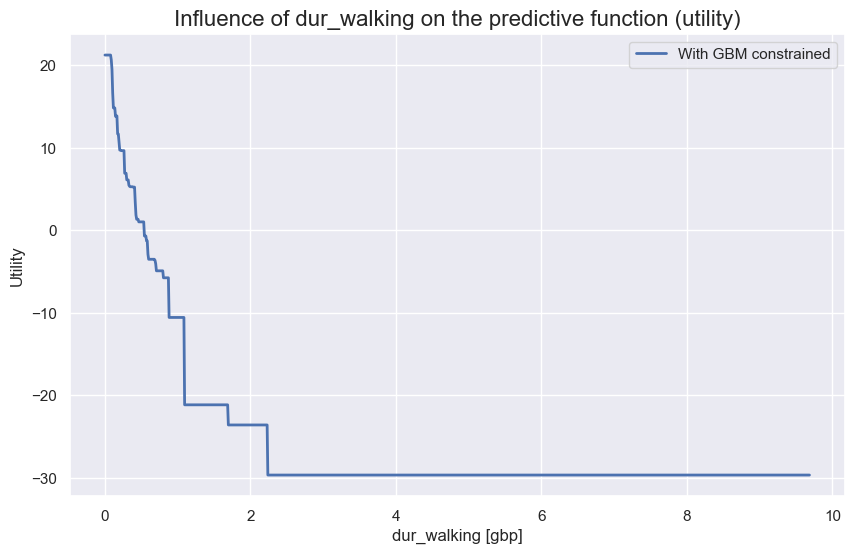

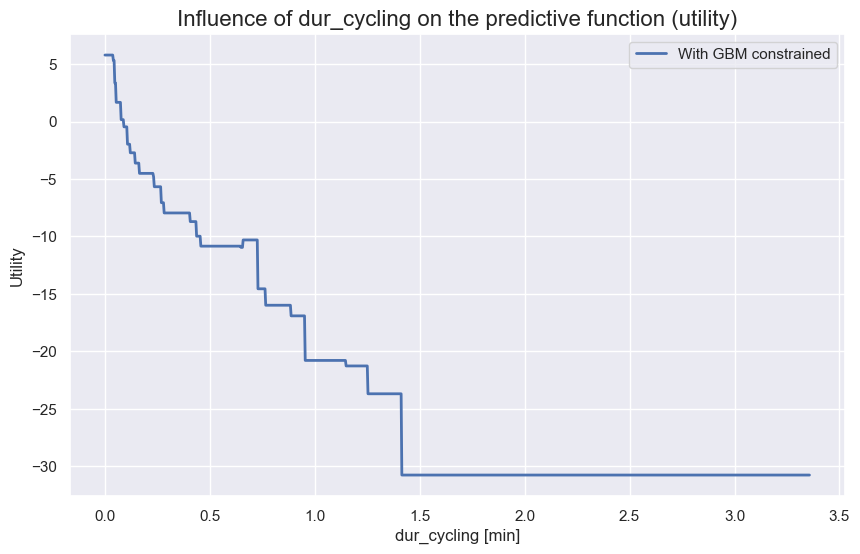

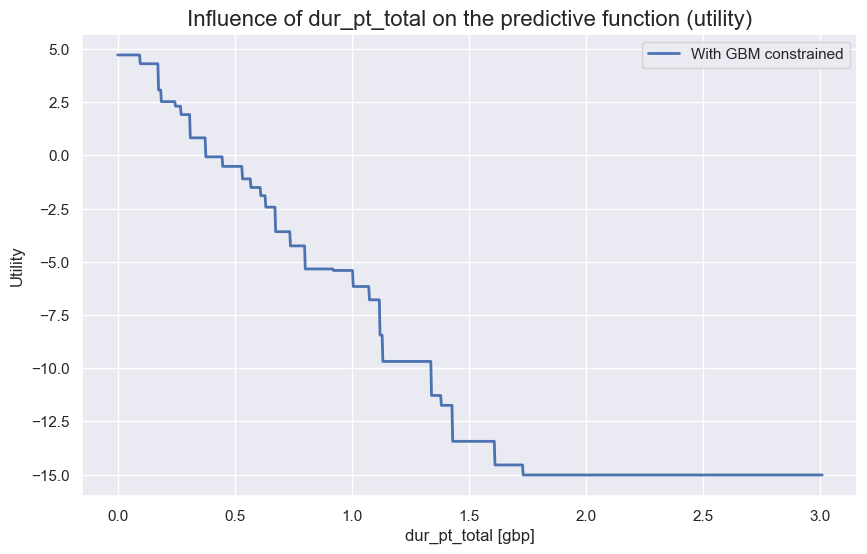

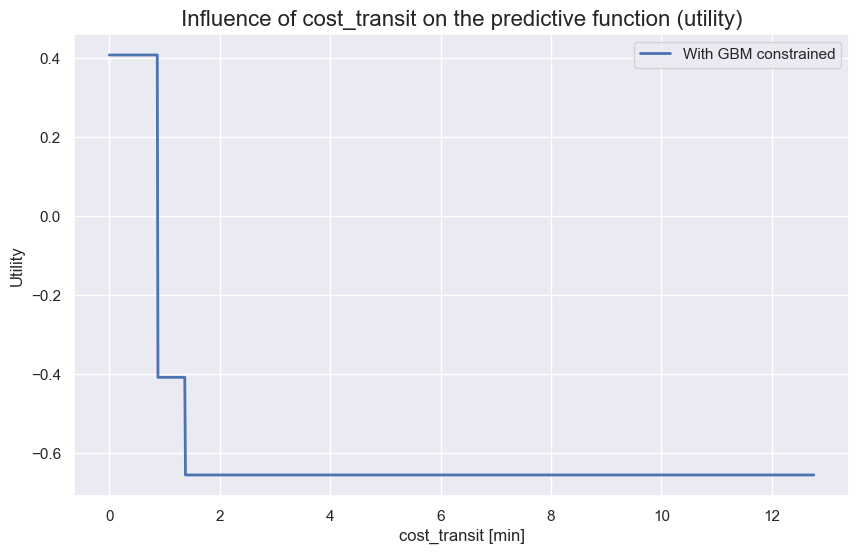

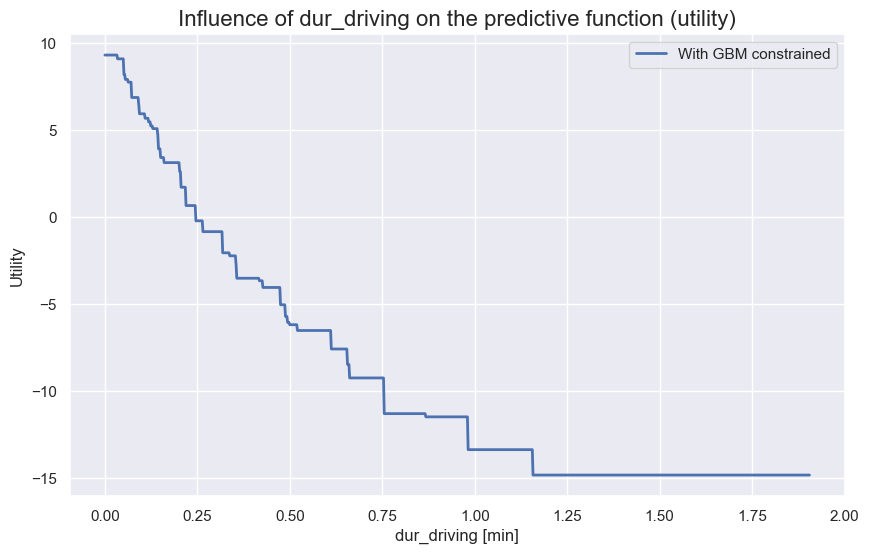

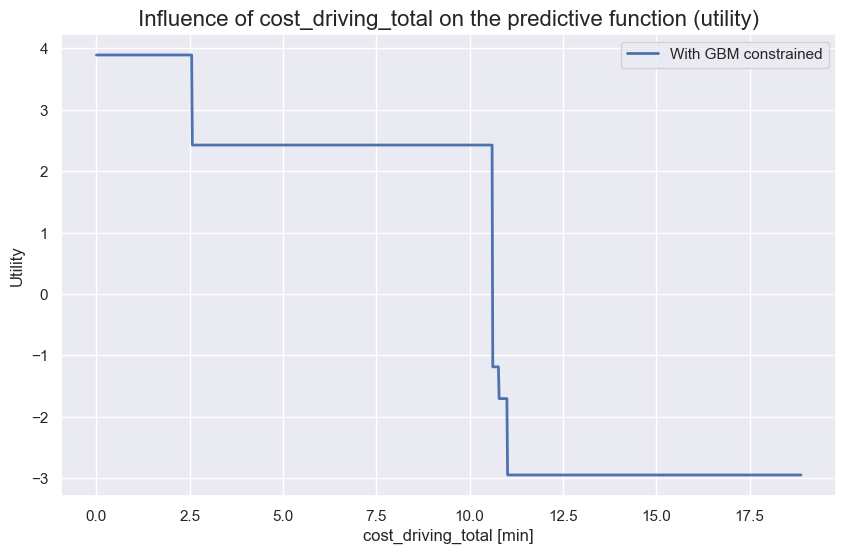

In [20]:
lightgbm_ld.plot_parameters(param_ld, X_train, ['gbp', 'min', 'gbp', 'min', 'min', 'min'])

In [46]:
param_ld_unc = {'max_depth': 1, 
         'num_boost_round': 300, 
         'objective':'multiclass',
         'learning_rate': 0.5,
         'verbosity': 1,
         'num_classes': 4
        }

In [47]:
lightgbm_ld_unc = lgb.train(param_ld_unc, train_data, valid_sets=[validation_data])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 7103, number of used features: 6
[LightGBM] [Info] Start training from score -0.463353
[LightGBM] [Info] Start training from score -1.492390
[LightGBM] [Info] Start training from score -3.720778
[LightGBM] [Info] Start training from score -2.105543
[1]	valid_0's multi_logloss: 0.838158
[2]	valid_0's multi_logloss: 0.79124
[3]	valid_0's multi_logloss: 0.771492
[4]	valid_0's multi_logloss: 0.757969
[5]	valid_0's multi_logloss: 0.748892
[6]	valid_0's multi_logloss: 0.742835
[7]	valid_0's multi_logloss: 0.736788
[8]	valid_0's multi_logloss: 0.734156
[9]	valid_0's multi_logloss: 0.73182
[10]	valid_0's multi_logloss: 0.72904
[11]	valid_0's multi_logloss: 0.725812
[12]	valid_0's multi_logloss: 0.724809
[13]	valid_0's multi_logloss: 0.722052